In [172]:
#store midi files as numpy arrays inside dict for easy iteration and look-up
!pip install mido
import os
import mido
import numpy as np

folder_path = 'midi_files'
midi_files = [f for f in os.listdir(folder_path)]
midi_dict = {}

for file in midi_files:
    sequence = np.zeros((8,8))
    midi = mido.MidiFile(f'{folder_path}/{file}')
    step = 0
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on':
                note = msg.note
                sequence[step%8][(note-4)%8] = 1
                step += 1
            elif msg.type == 'note_off':
                note = msg.note
                sequence[step%8][(note-4)%8] = 0
                step += 1
    midi_dict[os.path.splitext(file)[0]] = sequence
midi_dict.keys()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


dict_keys(['x23', 'y14', 'y3', 'y12', 'x1', 'x10', 'y8', 'y17', 'x4', 'x2', 'y10', 'y2', 'x19', 'x9', 'x3', 'x16', 'x7', 'x11', 'x13', 'y9', 'x21', 'y19', 'y23', 'y6', 'y15', 'y18', 'y4', 'y22', 'y16', 'y20', 'x18', 'y11', 'x8', 'x14', 'x17', 'y7', 'y1', 'y5', 'x20', 'x24', 'x5', 'y21', 'x12', 'y24', 'y13', 'x6', 'x15', 'x22'])

In [173]:
y_train = []
x_train = []
for i in midi_dict.items():
    value = midi_dict[i[0]]
    if i[0][0] == 'y':
        y_train.append(value)
    elif i[0][0] == 'x':
        x_train.append(value)

In [174]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [198]:
from tensorflow.keras import regularizers

optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model = keras.Sequential()
model.add(layers.Input(shape=(8,8),))
model.add(layers.SimpleRNN(64,kernel_regularizer=regularizers.l1(0.02)))
model.add(layers.Dense(64))
model.add(layers.Dropout(0.2))
model.add(layers.Reshape((8,8)))
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_39 (SimpleRNN)   (None, 64)                4672      
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 reshape_33 (Reshape)        (None, 8, 8)              0         
                                                                 
Total params: 8,832
Trainable params: 8,832
Non-trainable params: 0
_________________________________________________________________


In [176]:
x_test, y_test = x_train[0:2], y_train[0:2]
x_train, y_train = x_train[2:], y_train[2:]
print(len(x_train))
print(len(y_train))

18
18


In [177]:
import random
x_augment = []
y_augment = []
for arr in x_train:
  choice = random.randint(1, 3)
  if choice == 1:
    x_augment.append(np.flip(arr))
  elif choice == 2:
    x_augment.append(np.flip(arr, 1))
  elif choice == 3:
    x_augment.append(np.flip(arr, 0))
x_train = np.concatenate((x_train, x_augment))
for arr in y_train:
  choice = random.randint(1, 3)
  if choice == 1:
    y_augment.append(np.flip(arr))
  elif choice == 2:
    y_augment.append(np.flip(arr, 1))
  elif choice == 3:
    y_augment.append(np.flip(arr, 0))

y_train = np.concatenate((y_train, y_augment))


In [200]:
from tensorflow.keras import regularizers

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model = keras.Sequential()
model.add(layers.Input(shape=(8,8),))
model.add(layers.SimpleRNN(64,kernel_regularizer=regularizers.l1(0.02)))
model.add(layers.Dense(64))
model.add(layers.Dropout(0.2))
model.add(layers.Reshape((8,8)))
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
model.summary()

x_train = np.array(x_train)
y_train = np.array(y_train)

K = 4
num_val_samples = len(x_train) // K
num_epochs = 60
all_acc_histories = []
all_loss_histories = []

for i in range(K):
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    x_val = x_train[a : b]
    y_val = y_train[a : b]
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([x_train[:a], x_train[b:]])
    partial_train_targets = np.concatenate([y_train[:a], y_train[b:]])
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(x_val, y_val),
        epochs=num_epochs, batch_size=32)

    accuracy_history = history.history['val_accuracy']
    loss_history = history.history['loss']

    all_loss_histories.append(loss_history)
    all_acc_histories.append(loss_history)


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_40 (SimpleRNN)   (None, 64)                4672      
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 reshape_34 (Reshape)        (None, 8, 8)              0         
                                                                 
Total params: 8,832
Trainable params: 8,832
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
1/1 [==============================] - 110s 110s/step - loss: 1.6402 - accuracy: 0.1528 - val_loss: 1.6152 - val_accuracy: 0.1250
Epoch 2/60
1/1 [==========================

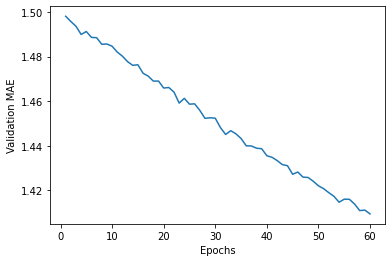

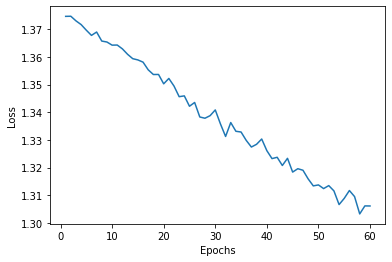

1/1 [==============================] - 0s 25ms/step - loss: 1.3173 - accuracy: 0.1875
loss — -> 1.3173422813415527
accuracy — -> 0.1875


In [201]:
import matplotlib.pyplot as plt
average_acc_history = np.array(all_acc_histories).mean(axis=0)
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

average_loss_history = np.array(all_loss_histories).mean(axis=0)
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

x_test = np.array(x_test)
y_test = np.array(y_test)

result = model.evaluate(x_test, y_test)
for i in range(len(result)):
    print(f'{model.metrics_names[i]} — -> {result[i]}')

In [203]:
from google.colab import files
export_dir = './saved_model'
tf.saved_model.save(model, export_dir=export_dir)
files.download(export_dir + '/saved_model.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>